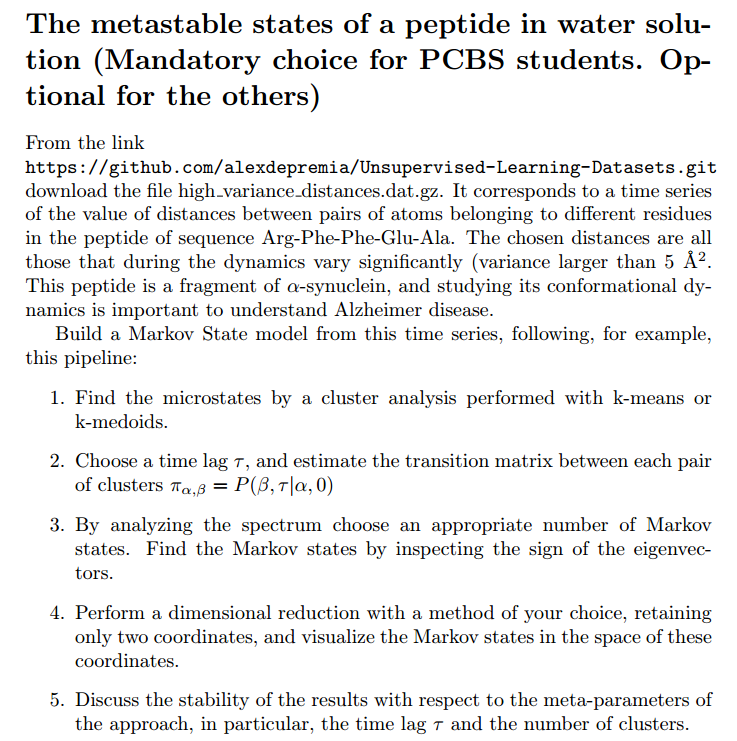

In [543]:
import numpy as np
import matplotlib.pyplot as plt

In [544]:
data = np.loadtxt('high_variance_distances.dat')

K Means

In [545]:
def k_medoids(data, k, max_iter=10):
    # Centroids indices are chosen randomly as rows from data
    # random.choiche draws random indices from range(number_of_rows). Replace = false makes sure that a number can be drawn only once
    centroids = np.random.choice(data.shape[0], k, replace=False)   # Indices of initial centroids
    old_centroids = centroids.copy()    # Will be used to check convergence
    
    for i in range(max_iter):
        clusters = [ list() for _ in centroids]    # Clusters is list of clusters, which in turn is a list of the indices of data

        # Assign data to closest centroid
        for t in range(data.shape[0]):
            dist_from_centroids = np.linalg.norm(data[t,:] - data[centroids], axis=1)
            # Append data index to cluster list
            clusters[np.argmin(dist_from_centroids)].append(t)

        # Compute new centroids
        centroids = []
        for cluster in clusters:
            center_of_cluster = np.average(data[cluster],axis=0)

            # Compute closest point
            dist_from_center = np.linalg.norm(data[cluster] - center_of_cluster, axis=1)
            new_centroid = cluster[np.argmin(dist_from_center)]
            centroids.append(new_centroid)

        # Verify Convergence
        if set(old_centroids) == set(centroids):
            print(f"Convergence obtained at iteration {i+1}!")
            old_centroids = centroids.copy()
            break

        # Print number of centroids that changed
        print(f'Number of centroids that changed: {len(set(centroids) - set(old_centroids))}')

        # Update Centroids
        old_centroids = centroids.copy()
    
    return centroids, clusters

In [546]:
def k_means(data, k, max_iter=10):
    # Centroids indices are chosen randomly as rows from data
    # random.choiche draws random indices from range(number_of_rows). Replace = false makes sure that a number can be drawn only once
    centroids = data[np.random.choice(data.shape[0], k, replace=False)]   # Indices of initial centroids
    old_centroids = centroids.copy()
    old_clusters = []   # Will be used to check convergence
    
    for i in range(max_iter):
        clusters = [ list() for _ in centroids]    # List of clusters. Every cluster is a list of the indices of data

        # Assign data to closest centroid
        for t in range(data.shape[0]):
            dist_from_centroids = np.linalg.norm(data[t,:] - centroids, axis=1)
            # Append data index to closest cluster list
            clusters[np.argmin(dist_from_centroids)].append(t)

        # Compute new centroids
        centroids = []
        for cluster in clusters:
            centroids.append(np.average(data[cluster],axis=0))
        centroids = np.array(centroids)

        # Convergence if clusters don't change
        # Comparison is done by recasting clusters as sets of frozensets
        if set([frozenset(cluster) for cluster in clusters]) == set([frozenset(cluster) for cluster in old_clusters]):
            print(f"Convergence obtained at iteration {i+1}!")
            old_centroids = centroids.copy()
            break

        # Print how much the centroids change on average
        print(f"Average change in centroids: {np.average(np.linalg.norm(old_centroids - centroids, axis=1))}")
        
        # Update Centroids
        old_centroids = centroids.copy()
        old_clusters = clusters.copy()
    
    return centroids, clusters

In [547]:
k = 500
max_iter = 10
centroids, clusters = k_medoids(data, k, max_iter)

Number of centroids that changed: 143
Number of centroids that changed: 40
Number of centroids that changed: 8
Number of centroids that changed: 1
Convergence obtained at iteration 5!


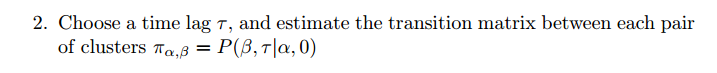

Transition Matrix Estimation

In [548]:
# Create an array traj[t] = i, where i is the cluster index of data[t]
traj = np.full(shape=data.shape[0], fill_value=None)  # Initialised as array of None (see assertation below)
for i,cluster in enumerate(clusters):
    for t in cluster:
        traj[t] = i

assert None not in traj   # Every t is assigned to a cluster

In [549]:
tau = 10

# Initialize transition matrix
K = np.zeros(shape=(k,k))
for i in range(len(traj[:-tau])):
    K[traj[i], traj[i+tau]] += 1

# Normalize such that sum along every row equals to one
sum_along_rows = np.sum(K, axis=1)
# Sometimes if tau is large enough some clusters are never visited.
clusters_never_visited = np.where(sum_along_rows < 0.5)[0]
# In this case we put 1 on the diagonal
for i in clusters_never_visited:
    K[i,i] = 1
K = K / np.sum(K, axis=1)[:,None]

assert np.allclose(np.sum(K, axis=1), np.ones(shape=K.shape[0]), atol=10) # Assert normalization (within numeric error)
assert np.all(K>=0) # Assert that all elements are non-negative


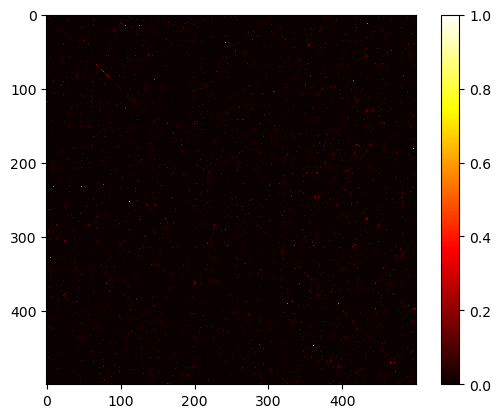

In [550]:
# plot trasition matrix colormap
plt.imshow(K, cmap='hot', interpolation='nearest')
plt.colorbar()


![Alt text](../Screenshot%20from%202023-03-17%2010-52-12.png)

In [551]:
# Eigenvalues and eigenvectors of the transition matrix
eigenvalues, eigenvectors = np.linalg.eig(K)
# Sort eigenvalues and eigenvectors by modulus of eigenvalue
idx = np.abs(eigenvalues).argsort()[::-1]
eigenvalues = eigenvalues[idx].copy()
eigenvectors = eigenvectors[:,idx].copy()

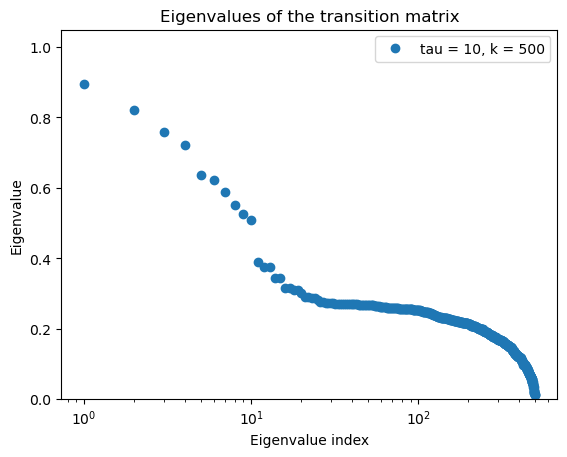

In [552]:
#Plot eigenvalues modolus
plt.plot(np.abs(eigenvalues), linestyle='None', marker='o', label = f'tau = {tau}, k = {k}')
plt.xlabel('Eigenvalue index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues of the transition matrix')
#plt.xlim(-10,k)
plt.ylim(0,None)
plt.xscale('log')
plt.legend()
plt.savefig(f'Figs/eigenvalues_tau{tau}_k{k}.png', dpi=300)
plt.show()


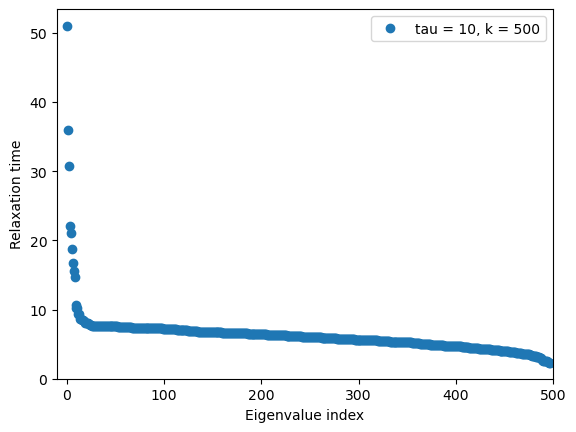

In [553]:
# Plot relaxation times
plt.plot(-tau/np.log(np.abs(eigenvalues[2:])), linestyle='None', marker='o', label = f'tau = {tau}, k = {k}')
plt.xlabel('Eigenvalue index')
plt.ylabel('Relaxation time')
plt.xlim(-10,k)
plt.ylim(0,None)
plt.legend()
plt.savefig(f'Figs/realxationtimes_tau{tau}_k{k}.png', dpi=300)
plt.show()

In [554]:
# Find Markov states
import itertools


d = 2
# Define Markov states as all possible permutations of d elements, each can be +1 and -1
Markov_states = np.array(list(itertools.product([-1,1], repeat=d)))
assert Markov_states.shape[0] == 2**d

# Dictionary that maps Markov states to their index
Markov_states_dict = {tuple(Markov_states[i]):i for i in range(2**d)}

# Now we assign each element of the trajectory to the corresponding Markov State
Markov_trajectory = []
for cluster_index in traj:
    signs = []
    for i in range(d):
        # append sign of the cluster_index-th component of the i-th eigenvector
        sign = np.sign(eigenvectors[cluster_index, i+1])
        if sign == 0:
            sign = 1.
        signs.append(sign)
    # Append Markov state to Markov trajectory
    Markov_trajectory.append(Markov_states_dict[tuple(signs)])


![Alt text](../Screenshot%20from%202023-03-17%2016-27-09.png)

In [555]:
# PCA
def CovMatrixVectorised(x):
    # Centering: subtract average from each row
    x = x - np.average(x, axis=0)
    # Assert sum of each row is zero
    assert np.allclose(np.sum(x, axis=0), np.zeros(shape=x.shape[1]))
    
    return np.cov(x.T)

C = CovMatrixVectorised(data)
C_eigenvalues , C_eigenvectors = np.linalg.eigh(C)

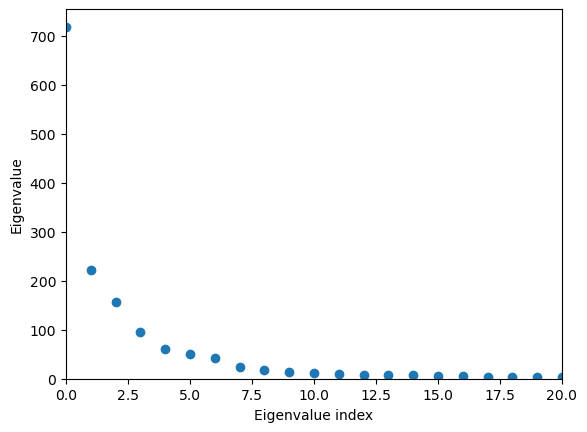

In [556]:
# Plot eigenvalues modolus in descending order
plt.plot(C_eigenvalues[::-1], linestyle='None', marker='o')
plt.xlabel('Eigenvalue index')
plt.ylabel('Eigenvalue')
plt.xlim(0,20)
plt.ylim(0,None)
plt.show()

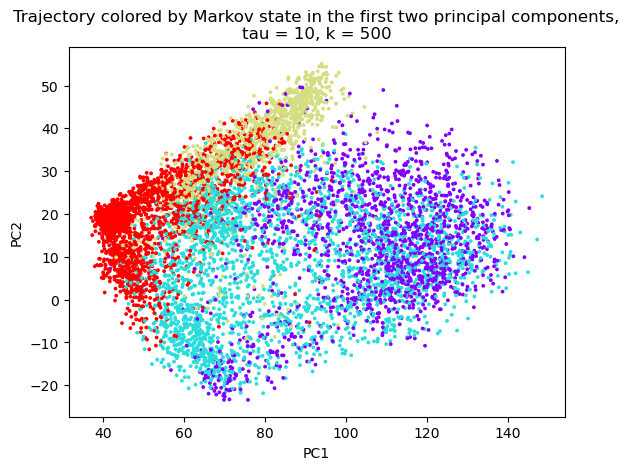

In [557]:
# Generate a list with n colors
colors = plt.cm.rainbow(np.linspace(0, 1, 2**d))
# Dictionary that plots Markov states to corresponding colors
Markov_states_colors = {tuple(Markov_states[i]):color for i,color in zip(range(2**d),colors)}

# Plot data colored by Markov state in the first two principal components
PC1 = np.dot(data, C_eigenvectors[:, -1])
PC2 = np.dot(data, C_eigenvectors[:, -2])
plt.scatter(PC1, -PC2, c=[Markov_states_colors[tuple(Markov_states[Markov_trajectory[i]])] for i in range(len(Markov_trajectory))], s=3)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f'Trajectory colored by Markov state in the first two principal components,\ntau = {tau}, k = {k}')
plt.savefig(f'Figs/Markov_states_tau{tau}_k{k}.png', dpi=300)
plt.show()